# Obssim analysis
Read output files, make plots to compare with data

In [1]:
%matplotlib inline
import glob, pickle
os.chdir(os.path.expandvars('$FERMI/skymodels/obssim_monthly'))
!ls

config.txt		   omonth03  omonth10  omonth17  omonth24
create_months.sh	   omonth04  omonth11  omonth18  plot_index.html
month00			   omonth05  omonth12  omonth19  run_tabes.sh
obssim_transients.csv	   omonth06  omonth13  omonth20  run_tables.sh
obssim_transients_cut.csv  omonth07  omonth14  omonth21  start_jobs.sh
omonth01		   omonth08  omonth15  omonth22
omonth02		   omonth09  omonth16  omonth23


In [2]:
sources = [pickle.load(open(f)) for f in glob.glob('omonth*/sources.pickle')]
nmonths = len(sources); nmonths

24

In [3]:
allsrc = pd.concat(sources, axis=0)
transients = allsrc[allsrc.transient]
len(allsrc), len(transients)

(34906, 6752)

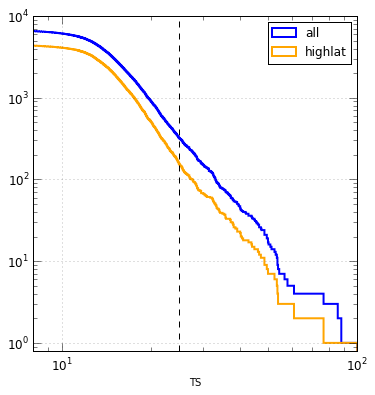

In [4]:
t = transients
fig, ax = plt.subplots(figsize=(6,6))
maxts=100
histkw= dict(bins=np.logspace(0,np.log10(maxts),1000), histtype='step', lw=2, cumulative=-1, log=True)
ax.hist(t.ts.clip(0,maxts), label='all', **histkw);
hilat = np.array(np.abs(t.glat)>10, bool)
ax.hist(t.ts[hilat].clip(0,maxts),color='orange', label='highlat', **histkw);
plt.setp(ax, xlim=(8,maxts), xlabel='TS', xscale='log', ylim=(0.8,None))
ax.axvline(25, color='k', ls='--')
ax.legend(); ax.grid(True, alpha=0.5);

In [5]:
sum(t.ts>10)/float(nmonths), sum(t.ts>25)/float(nmonths)

(254.08333333333334, 13.291666666666666)

### Scale to a single month

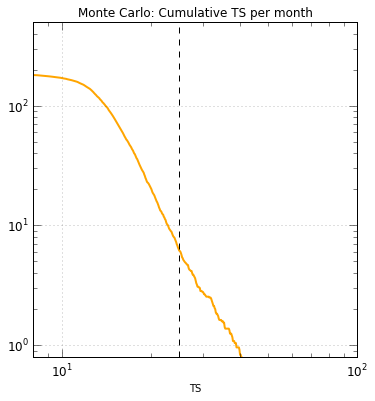

In [6]:
th = np.histogram(t.ts[hilat], histkw['bins'])
tot = sum(hilat)
fig, ax = plt.subplots(figsize=(6,6))
ax.loglog(th[1][:-1],(tot-th[0].cumsum())/float(nmonths), '-', color='orange', lw=2);
ax.axvline(25, color='k', ls='--')
plt.setp(ax, xlim=(8,maxts), xlabel='TS', xscale='log', ylim=(0.8,500))
ax.set_title('Monte Carlo: Cumulative TS per month')
ax.grid(True, alpha=0.5);


## Save a csv file

In [7]:
#oa.df.to_csv('obssim_transients.csv')

## Run the transient analysis

In [8]:
from uw.like2.analyze import transientinfo as ti; print reload(ti)

%time oa = ti.ObssimAnalysis()
print 'Obssim months found: {}, {} sources'.format(len(oa.monthinfo), len(oa.df))

<module 'uw.like2.analyze.transientinfo' from '/afs/slac/g/glast/groups/catalog/pointlike/python/uw/like2/analyze/transientinfo.pyc'>
CPU times: user 19.3 s, sys: 447 ms, total: 19.7 s
Wall time: 19.8 s
Obssim months found: 24, 5542 sources


### Cut out nearby sources

Comparing 5542 sources with 1829 in reference set


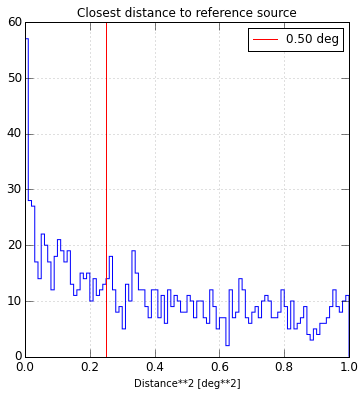

In [9]:
reload(ti)
cc = ti.CloseCut(oa.df.skydir, oa.df6y[oa.df6y.ts>100].skydir)
cc.plot();

In [10]:
oa.df[cc()].to_csv('obssim_transients_cut.csv')

effect of cut for these plots: from 5542 to 5094
lolat     :   1767
hilat     :   3775
assoc     :    246
unassoc   :   5296


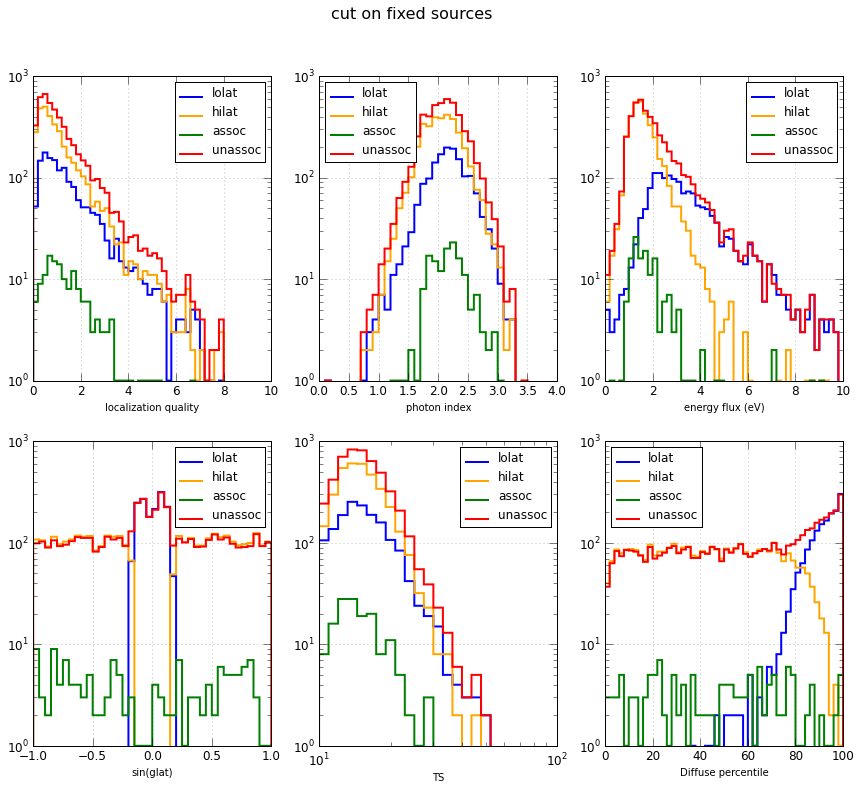

In [11]:
ti.plots2(oa, cc(), 'cut on fixed sources')

In [12]:
8500/72., 1767/24.

(118.05555555555556, 73.625)

effect of cut for these plots: from 5542 to 5542
lolat     :   1767
hilat     :   3775
assoc     :    246
unassoc   :   5296


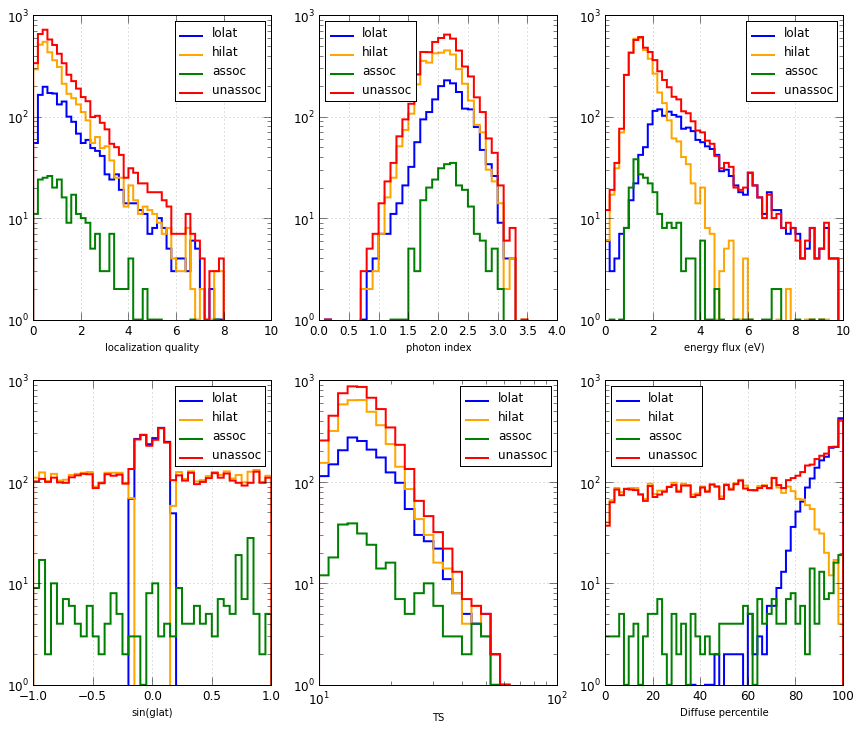

In [13]:
#oa.df.to_csv('obssim_transients.csv')
ti.plots2(oa)

/afs/slac/g/glast/groups/catalog/python/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1706: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


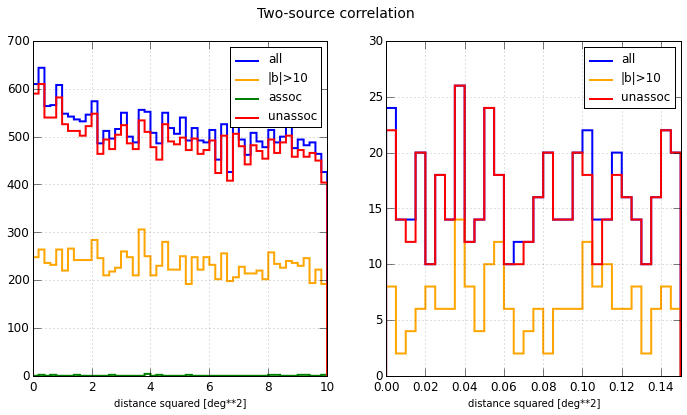

In [14]:
ti.pair_correlation_plots(oa, cc())

## Correlate with the (data) photon density
The code in transients.

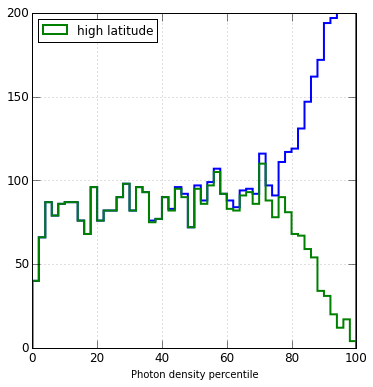

In [16]:
df = oa.df
fig, ax = plt.subplots(figsize=(6,6))
histkw = dict(bins=np.linspace(0,100, 51), histtype='step', lw=2)
ax.hist(df.kdepercentile, **histkw);
ax.hist(df.kdepercentile[abs(df.glat)>10], label='high latitude',**histkw)
ax.grid(True, alpha=0.5)
ax.legend(loc='upper left')
plt.setp(ax, ylim=(0,200), xlabel='Photon density percentile');

## Compare data and simulation

Read 27192 data sources from ../P301_monthly/transients_cut.csv, 72 months
Read 5094 simulated sources from obssim_transients_cut.csv, 24 months


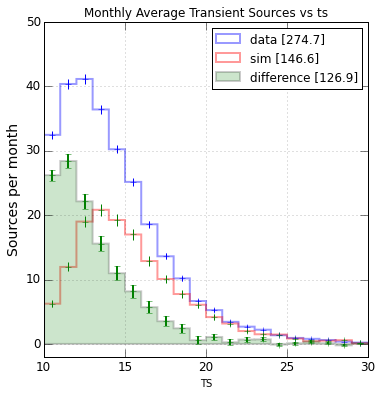

In [146]:
reload(ti)
q = ti.ObssimDataComparison()
q()

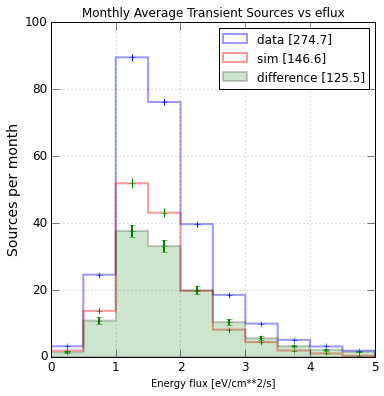

In [148]:
q('eflux',xlabel='Energy flux [eV/cm**2/s]', bins=np.linspace(0,5,11),
                  xscale='linear', ylim=(None,None))

applying cut has_assoc


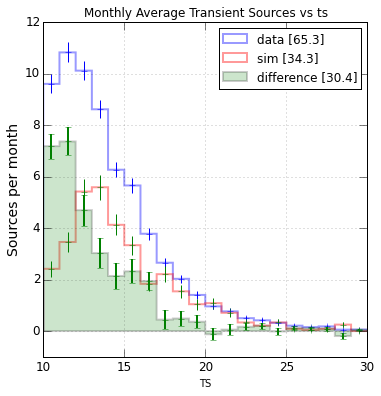

In [149]:
q(cut='has_assoc', ylim=(-1,None))

In [151]:
set(q.data.acat)
sum(q.data.acat=='bzcat'), sum(q.sim.acat=='bzcat')

(237, 28)

applying cut has_assoc


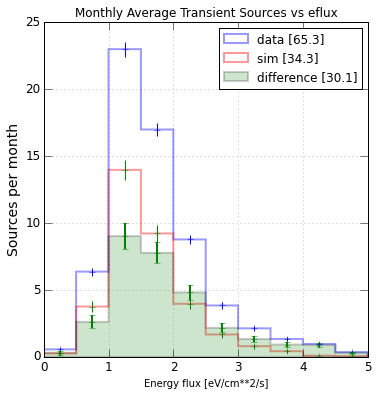

In [150]:
q('eflux',cut='has_assoc', xlabel='Energy flux [eV/cm**2/s]', bins=np.linspace(0,5,11),
                  xscale='linear', ylim=(None,None))

applying cut bzcat


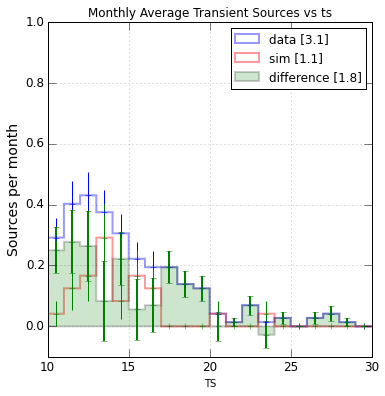

In [163]:
q.data['bzcat']=q.data.acat=='bzcat'
q.sim['bzcat']=q.sim.acat=='bzcat'
q(cut='bzcat', ylim=(-0.1,1))

In [179]:
def catlist(acat, name):
    cats =set(acat)
    ncat = dict()
    for cat in cats:
        n = sum(acat==cat)
        if n>2: ncat[cat] = n 
    return pd.DataFrame(ncat, index=[name]).T
data_cat =catlist(q.data.acat, 'data')
data_cat

,data
agn,11
bllac,39
bzcat,237
cgrabs,122
crates,493
pulsar_big,68
pulsar_lat,24
qso,67
starbursts,4


In [180]:
sim_cat=catlist(q.sim.acat, 'sim')
sim_cat

,sim
bllac,10
bzcat,28
cgrabs,15
crates,67
pulsar_big,8
qso,14


In [182]:
data_cat['sim']=sim_cat.sim
data_cat.data /= 72.
data_cat.sim /=24.
data_cat

,data,sim
agn,0.152778,NaN
bllac,0.541667,0.416667
bzcat,3.291667,1.166667
cgrabs,1.694444,0.625000
crates,6.847222,2.791667
pulsar_big,0.944444,0.333333
pulsar_lat,0.333333,NaN
qso,0.930556,0.583333
starbursts,0.055556,NaN


In [183]:
sum(data_cat.data), sum(data_cat.sim)

(14.791666666666668, nan)